# Voynich Manuscript Analysis

## Overview
This notebook analyzes the Voynich Manuscript, focusing on vocabulary uniqueness, functional word detection, vocabulary flow, and thematic clustering. The code processes a transliteration file (`transliteration_zl.txt`) to extract folios, compute metrics, and generate consolidated results. Key modifications include:
- Converting verbose print statements to Markdown explanations for clarity.
- Replacing functional word visualization with a table displaying actual words.
- Reducing excessive output to focus on key results.
- Ensuring meaningful word output in functional word analysis.
- Added Vocabulary Flow Analyzer to track vocabulary changes across folios and visualize transitions.

## Column Explanations
- **Uniqueness Analysis**:
  - *folio*: Folio identifier (e.g., '1r', '68v')
  - *folio_num*: Numeric folio number
  - *section*: Thematic section (e.g., Herbal_A, Recipes)
  - *uniqueness_score*: Ratio of words unique to local window (0-1, higher = more distinctive)
  - *overlap_score*: Ratio of words shared with rest of manuscript (0-1)
  - *window_vocab_size*: Total unique words in surrounding window
  - *unique_words_count*: Number of words found only in this local area
  - *target_folio_word_count*: Total words in this specific folio
  - *target_unique_words*: How many unique words appear in this folio
  - *unique_words_sample*: Examples of words unique to this area

- **Boundary Analysis**:
  - *section_start*: Name of section starting at boundary
  - *boundary_folio*: Folio number where section starts
  - *uniqueness_before*: Average uniqueness score before boundary
  - *uniqueness_at_boundary*: Uniqueness score at boundary folio
  - *uniqueness_after*: Average uniqueness score after boundary
  - *boundary_jump*: Change in uniqueness at boundary (positive = increase)

- **Functional Word Analysis**:
  - *word*: Analyzed word from the manuscript
  - *section*: Section where word appears
  - *frequency*: Word frequency in section
  - *frequency_rank*: Rank of word frequency
  - *entropy*: Conditional entropy of word (higher = more varied contexts)
  - *functional_score*: Combined score (0-1, higher = more likely functional)
  - *classification*: 'highly_functional', 'possibly_functional', or 'likely_content'
  - *similarity_variance*: Variance of embedding similarities
  - *similarity_mean*: Mean of embedding similarities

- **Functional Word Comparison**:
  - *section_1*, *section_2*: Sections being compared
  - *functional_words_1*, *functional_words_2*: Number of functional words in each section
  - *shared_functional_words*: Number of shared functional words
  - *jaccard_similarity*: Jaccard similarity of functional word sets (0-1)
  - *shared_words*: Sample of shared functional words

- **Vocabulary Flow Analysis**:
  - *folio_current*, *folio_next*: Folios in transition
  - *folio_num_current*, *folio_num_next*: Numeric folio numbers
  - *current_section*, *next_section*: Sections of folios
  - *section_boundary*: True if transition crosses section boundary
  - *jaccard_similarity*: Jaccard similarity of vocabularies (0-1)
  - *cosine_similarity*: Cosine similarity of vocabulary counts (0-1)
  - *current_unique_words*, *next_unique_words*: Unique word counts
  - *current_total_words*, *next_total_words*: Total word counts
  - *vocabulary_size_change*: Change in unique word count

- **Boundary Validation**:
  - *known_boundary*: Known section boundary folio
  - *section_name*: Section starting at boundary
  - *detected*: True if boundary detected within ±2 folios
  - *detection_count*: Number of detected boundaries nearby
  - *min_jaccard_similarity*: Minimum Jaccard similarity at boundary
  - *min_cosine_similarity*: Minimum cosine similarity at boundary
  - *boundary_strength*: 1 - min(similarities) (higher = stronger boundary)

- **Section Continuity**:
  - *section*: Manuscript section
  - *internal_transitions*: Number of folio transitions within section
  - *avg_jaccard_similarity*: Average Jaccard similarity within section
  - *min_jaccard_similarity*, *max_jaccard_similarity*: Range of similarities
  - *vocabulary_consistency*: 'high' if avg Jaccard > 0.5, else 'low'

- **Cluster-Section Alignment**:
  - *cluster_id*: Cluster identifier
  - *word_count*: Number of words in cluster
  - *total_occurrences*: Total occurrences of cluster words
  - *dominant_section*: Section with most occurrences
  - *dominant_percentage*: Percentage of occurrences in dominant section
  - *cluster_purity*: Ratio of dominant section occurrences (0-1)
  - *section_entropy*: Entropy of section distribution
  - *example_words*: Sample words in cluster
  - *sections_represented*: Number of sections in cluster

- **Section Validation**:
  - *section*: Manuscript section
  - *dominant_clusters*: Number of clusters dominated by section
  - *avg_cluster_purity*: Average purity of section's clusters
  - *total_clustered_words*: Total words in section's clusters
  - *best_cluster_id*: ID of highest-purity cluster
  - *best_cluster_purity*: Purity of best cluster
  - *best_cluster_words*: Sample words in best cluster
  - *thematic_distinctiveness*: 'high', 'moderate', or 'low' based on purity

- **Cross-Section Vocabulary**:
  - *word*: Word appearing in multiple sections
  - *sections_count*: Number of sections word appears in
  - *total_occurrences*: Total word occurrences
  - *primary_section*: Section with most occurrences
  - *primary_percentage*: Percentage of occurrences in primary section
  - *all_sections*: Sections where word appears
  - *cluster_id*: Cluster assignment
  - *distribution_pattern*: 'specialized' (>70% in one section) or 'distributed'

In [1]:
!pip install -r requirements.txt

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Import Libs
import numpy as np
import pandas as pd
from collections import Counter, defaultdict
import re
import math
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [4]:
class VoynichUtils:
    """Shared utilities for Voynich Manuscript analysis."""
    @staticmethod
    def sort_folios(vocabularies):
        return sorted(vocabularies.items(), key=lambda x: (x[1]['folio_num'], x[0]))

    @staticmethod
    def make_readable_sample(items, limit=5, none_text='none'):
        sample = sorted(list(items))[:limit]
        return ', '.join(sample) if sample else none_text

    @staticmethod
    def train_embeddings(words, vector_size=64, window=3, epochs=15, step=2):
        sentences = [words[i:i + 5] for i in range(0, len(words) - 4, step)]
        if len(sentences) < 5:
            return None
        try:
            model = Word2Vec(sentences=sentences, vector_size=vector_size, window=window,
                            min_count=1, workers=4, sg=1, epochs=epochs, seed=42)
            return {word: model.wv[word] for word in model.wv.key_to_index.keys()}
        except Exception:
            return None

    @staticmethod
    def jaccard_similarity(vocab1, vocab2):
        set1 = set(vocab1.keys() if hasattr(vocab1, 'keys') else vocab1)
        set2 = set(vocab2.keys() if hasattr(vocab2, 'keys') else vocab2)
        intersection = set1 & set2
        union = set1 | set2
        return len(intersection) / len(union) if union else 0

    @staticmethod
    def cosine_similarity_vocab(vocab1, vocab2):
        all_words = set(vocab1.keys()) | set(vocab2.keys()) if hasattr(vocab1, 'keys') else set(vocab1) | set(vocab2)
        vec1 = np.array([vocab1.get(word, 0) for word in all_words])
        vec2 = np.array([vocab2.get(word, 0) for word in all_words])
        dot_product = np.dot(vec1, vec2)
        magnitude = np.linalg.norm(vec1) * np.linalg.norm(vec2)
        return dot_product / magnitude if magnitude else 0

In [5]:
# Manuscript Loader
class VoynichManuscriptLoader:
    def __init__(self, filepath='transliteration_zl.txt'):
        self.filepath = filepath
        self.raw_text = None
        self.folio_data = {}
        self.section_boundaries = {1: 'Herbal_A', 68: 'Astronomical', 75: 'Biological',
                                  102: 'Cosmetic', 107: 'Herbal_B', 113: 'Recipes'}
        self.folio_to_section = {}

    def load_raw_text(self):
        try:
            with open(self.filepath, 'r', encoding='utf-8') as f:
                self.raw_text = f.read()
            return True
        except FileNotFoundError:
            return False

    def parse_all_folios(self, glyph_level=False, treat_commas_as_spaces=True):
        if not self.raw_text and not self.load_raw_text():
            return 0
        lines = self.raw_text.strip().split('\n')
        current_folio = None
        current_folio_key = None
        folio_pattern = r'<f(\d+)([rv])?\.'
        for line in lines:
            line = line.strip()
            if not line or line.startswith('#'):
                continue
            # Clean the line first
            cleaned_line = line
            cleaned_line = re.sub(r'@\d+', '', cleaned_line)  # Remove inline reference numbers
            cleaned_line = re.sub(r'<![^>]*>', '', cleaned_line)  # Remove complex comments
            cleaned_line = re.sub(r'<[^>]*>', '', cleaned_line)  # Remove other tags
            def replace_uncertain(match):
                options = match.group(1).split(':')
                return options[0] if options else ''
            cleaned_line = re.sub(r'\[([^\]]+)\]', replace_uncertain, cleaned_line)  # Handle uncertain readings
            cleaned_line = re.sub(r'[{}]', '', cleaned_line)  # Remove ligature braces
            cleaned_line = re.sub(r'\?+', '', cleaned_line)  # Remove question marks
            # Handle dots and commas before splitting
            if treat_commas_as_spaces:
                cleaned_line = cleaned_line.replace('.', ' ').replace(',', ' ')
            else:
                cleaned_line = cleaned_line.replace('.', ' ').replace(',', '')
            cleaned_line = re.sub(r'\s+', ' ', cleaned_line).strip().lower()
            # Check for folio marker
            folio_match = re.search(folio_pattern, line)  # Match on original line to preserve tags
            if folio_match:
                current_folio = int(folio_match.group(1))
                folio_side = folio_match.group(2) or 'r'
                current_folio_key = f"{current_folio}{folio_side}"
                folio_text = cleaned_line
            else:
                folio_text = cleaned_line
            if current_folio and folio_text:
                if current_folio_key not in self.folio_data:
                    self.folio_data[current_folio_key] = {'folio_num': current_folio, 'folio_side': folio_side,
                                                         'raw_text': [], 'clean_words': [], 'clean_glyphs': []}
                self.folio_data[current_folio_key]['raw_text'].append(folio_text)
                if glyph_level:
                    # Apply same cleaning to glyphs
                    glyphs = list(folio_text)
                    glyphs = [g for g in glyphs if g.isalpha()]  # Keep only alphabetic glyphs
                    self.folio_data[current_folio_key]['clean_glyphs'].extend(glyphs)
                words = folio_text.split()
                clean_words = [w for w in words if re.match(r'^[a-z]+$', w) and len(w) > 1]
                self.folio_data[current_folio_key]['clean_words'].extend(clean_words)
        self._map_folios_to_sections()
        return len(self.folio_data)

    def _map_folios_to_sections(self):
        for folio_key, folio_info in self.folio_data.items():
            folio_num = folio_info['folio_num']
            assigned_section = 'Unknown'
            for boundary_folio, section_name in sorted(self.section_boundaries.items()):
                if folio_num >= boundary_folio:
                    assigned_section = section_name
            self.folio_to_section[folio_key] = assigned_section
            self.folio_data[folio_key]['section'] = assigned_section

    def get_folio_statistics(self):
        if not self.folio_data:
            self.parse_all_folios()
        stats = {'total_folios': len(self.folio_data),
                 'unique_folio_numbers': len(set(info['folio_num'] for info in self.folio_data.values())),
                 'recto_pages': len([k for k in self.folio_data.keys() if k.endswith('r')]),
                 'verso_pages': len([k for k in self.folio_data.keys() if k.endswith('v')]),
                 'folio_range': f"{min(info['folio_num'] for info in self.folio_data.values())}-{max(info['folio_num'] for info in self.folio_data.values())}",
                 'sections': {}, 'glyph_stats': {}}
        for section in self.section_boundaries.values():
            section_folios = [k for k, info in self.folio_data.items() if info['section'] == section]
            section_words = [w for k in section_folios for w in self.folio_data[k]['clean_words']]
            section_glyphs = [g for k in section_folios for g in self.folio_data[k]['clean_glyphs']]
            stats['sections'][section] = {'folios': len(section_folios), 'total_words': len(section_words),
                                         'unique_words': len(set(section_words)), 'top_words': Counter(section_words).most_common(5)}
            stats['glyph_stats'][section] = {'total_glyphs': len(section_glyphs), 'unique_glyphs': len(set(section_glyphs))}
        return stats

    def get_section_text(self, section_name):
        if not self.folio_data:
            self.parse_all_folios()
        return [w for k, info in self.folio_data.items() if info['section'] == section_name for w in info['clean_words']]

    def get_folio_vocabularies(self):
        if not self.folio_data:
            self.parse_all_folios()
        return {k: {'folio_num': info['folio_num'], 'section': info['section'], 'words': info['clean_words'],
                    'vocab_counter': Counter(info['clean_words'])} for k, info in self.folio_data.items()}

    def get_word_section_mapping(self):
        if not self.folio_data:
            self.parse_all_folios()
        word_sections = defaultdict(list)
        for folio_key, folio_info in self.folio_data.items():
            for word in folio_info['clean_words']:
                word_sections[word].append(folio_info['section'])
        return dict(word_sections)

    def get_all_clean_words(self):
        if not self.folio_data:
            self.parse_all_folios()
        return [w for info in self.folio_data.values() for w in info['clean_words']]

In [6]:
# Vocabulary Uniqueness Mapper
class VocabularyUniquenessMapper:
    def __init__(self, manuscript_loader, config=None):
        self.manuscript_loader = manuscript_loader
        self.config = config or {'window_size': 3}
        self.folio_vocabularies = None

    def calculate_vocabulary_uniqueness(self):
        self.folio_vocabularies = self.manuscript_loader.get_folio_vocabularies()
        sorted_folio_items = VoynichUtils.sort_folios(self.folio_vocabularies)
        uniqueness_results = []
        for i, (target_folio_key, target_folio_data) in enumerate(sorted_folio_items):
            window_start = max(0, i - self.config['window_size'])
            window_end = min(len(sorted_folio_items), i + self.config['window_size'] + 1)
            window_folios = sorted_folio_items[window_start:window_end]
            window_vocab = set(w for _, folio_data in window_folios for w in folio_data['words'])
            rest_vocab = set(w for j, (_, folio_data) in enumerate(sorted_folio_items) if j < window_start or j >= window_end for w in folio_data['words'])
            unique_to_window = window_vocab - rest_vocab
            uniqueness_ratio = len(unique_to_window) / len(window_vocab) if window_vocab else 0
            overlap_ratio = len(window_vocab & rest_vocab) / len(window_vocab) if window_vocab else 0
            target_vocab = set(target_folio_data['words'])
            uniqueness_results.append({
                'folio': target_folio_key, 'folio_num': target_folio_data['folio_num'], 'section': target_folio_data['section'],
                'uniqueness_score': round(uniqueness_ratio, 4), 'overlap_score': round(overlap_ratio, 4),
                'window_vocab_size': len(window_vocab), 'unique_words_count': len(unique_to_window),
                'target_folio_word_count': len(target_folio_data['words']), 'target_unique_words': len(target_vocab & unique_to_window),
                'unique_words_sample': VoynichUtils.make_readable_sample(unique_to_window)
            })
        return pd.DataFrame(uniqueness_results)

    def section_boundary_analysis(self, uniqueness_df):
        boundary_analysis = []
        for boundary_folio, section_name in self.manuscript_loader.section_boundaries.items():
            boundary_rows = uniqueness_df[(uniqueness_df['folio_num'] >= boundary_folio - 3) & (uniqueness_df['folio_num'] <= boundary_folio + 3)]
            if not boundary_rows.empty:
                before = boundary_rows[boundary_rows['folio_num'] < boundary_folio]['uniqueness_score'].mean()
                at = boundary_rows[boundary_rows['folio_num'] == boundary_folio]['uniqueness_score'].mean() or 0
                after = boundary_rows[boundary_rows['folio_num'] > boundary_folio]['uniqueness_score'].mean()
                boundary_analysis.append({'section_start': section_name, 'boundary_folio': boundary_folio,
                                         'uniqueness_before': round(before, 4) if not np.isnan(before) else 0,
                                         'uniqueness_at_boundary': round(at, 4),
                                         'uniqueness_after': round(after, 4) if not np.isnan(after) else 0,
                                         'boundary_jump': round(at - before, 4) if not np.isnan(before) else 0})
        return pd.DataFrame(boundary_analysis)

    def visualize_uniqueness(self, uniqueness_df):
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.plot(uniqueness_df['folio_num'], uniqueness_df['uniqueness_score'], label='Uniqueness Score', color='#1f77b4')
        boundaries = sorted(self.manuscript_loader.section_boundaries.items())[1:]
        for boundary_folio, section_name in boundaries:
            ax.axvline(x=boundary_folio, color='red', linestyle='--', alpha=0.5)
            ax.annotate(section_name, xy=(boundary_folio, -0.05), xycoords=('data', 'axes fraction'),
                        ha='center', va='top', fontsize=8, rotation=45)
        ax.set_xlabel('Folio Number')
        ax.set_ylabel('Uniqueness Score')
        ax.set_title('Vocabulary Uniqueness Across Folios')
        ax.legend()
        ax.tick_params(axis='x', rotation=45)
        plt.tight_layout()
        plt.show()

In [7]:
# Functional Word Analyzer
class FunctionalWordSectionAnalyzer:
    def __init__(self, manuscript_loader):
        self.manuscript_loader = manuscript_loader

    def conditional_entropy(self, tokens, word):
        word_positions = [i for i, token in enumerate(tokens) if token == word]
        if len(word_positions) < 2:
            return 0
        contexts = [tokens[pos + 1] for pos in word_positions if pos + 1 < len(tokens)]
        if not contexts:
            return 0
        context_counter = Counter(contexts)
        total_contexts = len(contexts)
        return sum(-(count/total_contexts) * math.log2(count/total_contexts) for count in context_counter.values())

    def detect_functional_words_per_section(self, section_name, min_frequency=2):
        section_words = self.manuscript_loader.get_section_text(section_name)
        if len(section_words) < 20:
            return pd.DataFrame()
        word_freq = Counter(section_words)
        embeddings = VoynichUtils.train_embeddings(section_words, vector_size=32, step=3)
        if not embeddings:
            return pd.DataFrame()
        candidate_words = [w for w in word_freq.keys() if w in embeddings and word_freq[w] >= min_frequency]
        if len(candidate_words) < 3:
            return pd.DataFrame()
        results = []
        for word in candidate_words:
            frequency = word_freq[word]
            frequency_rank = sorted(word_freq.values(), reverse=True).index(frequency) + 1
            frequency_percentile = (len(word_freq) - frequency_rank + 1) / len(word_freq)
            entropy = self.conditional_entropy(section_words, word)
            candidate_entropies = [self.conditional_entropy(section_words, w) for w in candidate_words]
            entropy_percentile = sum(1 for e in candidate_entropies if e <= entropy) / len(candidate_entropies)
            word_vector = embeddings[word].reshape(1, -1)
            other_words = [w for w in candidate_words[:20] if w != word]
            if len(other_words) >= 3:
                other_vectors = np.array([embeddings[w] for w in other_words])
                similarities = cosine_similarity(word_vector, other_vectors)[0]
                similarity_variance = np.var(similarities)
                similarity_mean = np.mean(similarities)
                functional_score = (frequency_percentile + entropy_percentile + (1 - similarity_variance)) / 3
                classification = ('highly_functional' if functional_score > 0.9 else
                                 'possibly_functional' if functional_score > 0.7 else 'likely_content')
                results.append({
                    'word': word,
                    'section': section_name,
                    'frequency': frequency,
                    'frequency_rank': frequency_rank,
                    'entropy': round(entropy, 4),
                    'functional_score': round(functional_score, 4),
                    'classification': classification,
                    'similarity_variance': round(similarity_variance, 4),
                    'similarity_mean': round(similarity_mean, 4)
                })
        return pd.DataFrame(results)

In [8]:
# Vocabulary Flow Analyzer
class VocabularyFlowAnalyzer:
    def __init__(self, manuscript_loader):
        self.manuscript_loader = manuscript_loader

    def calculate_vocabulary_flow(self):
        folio_vocabularies = self.manuscript_loader.get_folio_vocabularies()
        sorted_folio_items = VoynichUtils.sort_folios(folio_vocabularies)
        flow_results = []
        for i in range(len(sorted_folio_items) - 1):
            current_folio_key, current_data = sorted_folio_items[i]
            next_folio_key, next_data = sorted_folio_items[i + 1]
            jaccard_sim = VoynichUtils.jaccard_similarity(current_data['vocab_counter'], next_data['vocab_counter'])
            cosine_sim = VoynichUtils.cosine_similarity_vocab(current_data['vocab_counter'], next_data['vocab_counter'])
            flow_results.append({'folio_current': current_folio_key, 'folio_next': next_folio_key,
                                'folio_num_current': current_data['folio_num'], 'folio_num_next': next_data['folio_num'],
                                'current_section': current_data['section'], 'next_section': next_data['section'],
                                'section_boundary': current_data['section'] != next_data['section'],
                                'jaccard_similarity': round(jaccard_sim, 4), 'cosine_similarity': round(cosine_sim, 4),
                                'current_unique_words': len(current_data['vocab_counter']), 'next_unique_words': len(next_data['vocab_counter']),
                                'current_total_words': sum(current_data['vocab_counter'].values()), 'next_total_words': sum(next_data['vocab_counter'].values()),
                                'vocabulary_size_change': len(next_data['vocab_counter']) - len(current_data['vocab_counter'])})
        return pd.DataFrame(flow_results)

    def detect_vocabulary_boundaries(self, flow_df, similarity_threshold=0.3):
        detected_boundaries = [{'detected_boundary_folio': row['folio_num_next'], 'detected_boundary_key': row['folio_next'],
                               'jaccard_similarity': row['jaccard_similarity'], 'cosine_similarity': row['cosine_similarity'],
                               'actual_section_boundary': row['section_boundary'], 'next_section': row['next_section']}
                              for idx, row in flow_df.iterrows() if row['jaccard_similarity'] < similarity_threshold or row['cosine_similarity'] < similarity_threshold]
        detected_df = pd.DataFrame(detected_boundaries)
        validation_results = []
        for boundary_folio, section_name in self.manuscript_loader.section_boundaries.items():
            if boundary_folio > 1:
                detected = detected_df[abs(detected_df['detected_boundary_folio'] - boundary_folio) <= 2]
                boundary_rows = flow_df[(flow_df['folio_num_next'] >= boundary_folio - 1) & (flow_df['folio_num_next'] <= boundary_folio + 1)]
                min_jaccard = boundary_rows['jaccard_similarity'].min() if not boundary_rows.empty else 1.0
                min_cosine = boundary_rows['cosine_similarity'].min() if not boundary_rows.empty else 1.0
                validation_results.append({'known_boundary': boundary_folio, 'section_name': section_name, 'detected': len(detected) > 0,
                                          'detection_count': len(detected), 'min_jaccard_similarity': round(min_jaccard, 4),
                                          'min_cosine_similarity': round(min_cosine, 4), 'boundary_strength': round(1 - min(min_jaccard, min_cosine), 4)})
        return detected_df, pd.DataFrame(validation_results)

    def section_continuity_analysis(self, flow_df):
        section_stats = []
        for section in self.manuscript_loader.section_boundaries.values():
            section_flows = flow_df[(flow_df['current_section'] == section) & (flow_df['next_section'] == section)]
            if not section_flows.empty:
                section_stats.append({'section': section, 'internal_transitions': len(section_flows),
                                     'avg_jaccard_similarity': round(section_flows['jaccard_similarity'].mean(), 4),
                                     'min_jaccard_similarity': round(section_flows['jaccard_similarity'].min(), 4),
                                     'max_jaccard_similarity': round(section_flows['jaccard_similarity'].max(), 4),
                                     'vocabulary_consistency': 'high' if section_flows['jaccard_similarity'].mean() > 0.5 else 'low'})
        return pd.DataFrame(section_stats)

    def visualize_flow(self, flow_df):
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.plot(flow_df['folio_num_next'], flow_df['jaccard_similarity'], label='Jaccard Similarity', color='#ff7f0e')
        ax.plot(flow_df['folio_num_next'], flow_df['cosine_similarity'], label='Cosine Similarity', color='#2ca02c')
        boundaries = sorted(self.manuscript_loader.section_boundaries.items())[1:]
        for boundary_folio, section_name in boundaries:
            ax.axvline(x=boundary_folio, color='red', linestyle='--', alpha=0.5)
            ax.annotate(section_name, xy=(boundary_folio, -0.05), xycoords=('data', 'axes fraction'),
                        ha='center', va='top', fontsize=8, rotation=45)
        ax.set_xlabel('Folio Transition')
        ax.set_ylabel('Similarity')
        ax.set_title('Vocabulary Flow Across Folio Transitions')
        ax.legend()
        ax.tick_params(axis='x', rotation=45)
        plt.tight_layout()
        plt.show()

## Vocabulary Flow Analysis
This section analyzes how vocabulary changes between consecutive folios, measuring similarity (Jaccard and Cosine) to detect transitions and section boundaries. It includes:
- **Flow Calculation**: Compares vocabularies of adjacent folios, tracking unique/total words and similarity metrics.
- **Boundary Detection**: Identifies potential section boundaries where similarity drops below a threshold (0.3).
- **Section Continuity**: Measures vocabulary consistency within sections based on internal transitions.
- **Visualization**: Plots Jaccard and Cosine similarities across folio transitions, with red dashed lines marking known section boundaries.

In [9]:
# Initialize Manuscript Loader
manuscript_loader = VoynichManuscriptLoader()
manuscript_loader.parse_all_folios()

# Initialize Analyzers
uniqueness_mapper = VocabularyUniquenessMapper(manuscript_loader)
functional_analyzer = FunctionalWordSectionAnalyzer(manuscript_loader)
flow_analyzer = VocabularyFlowAnalyzer(manuscript_loader)

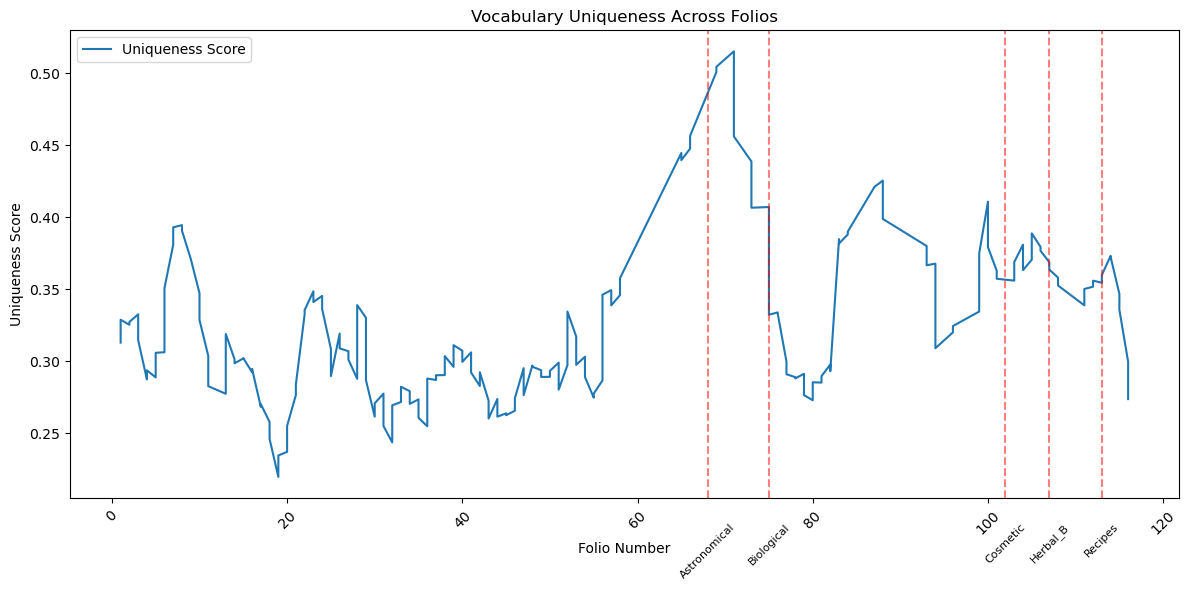

In [10]:
# Uniqueness Analysis
uniqueness_df = uniqueness_mapper.calculate_vocabulary_uniqueness()
boundary_df = uniqueness_mapper.section_boundary_analysis(uniqueness_df)
uniqueness_mapper.visualize_uniqueness(uniqueness_df)

In [11]:
# Functional Word Analysis
functional_dfs = []
for section in manuscript_loader.section_boundaries.values():
    df = functional_analyzer.detect_functional_words_per_section(section)
    if not df.empty:
        functional_dfs.append(df)
functional_table = pd.concat(functional_dfs, ignore_index=True)
functional_table = functional_table[functional_table['classification'] == 'highly_functional'][['section', 'word', 'functional_score', 'frequency', 'classification']]

# Functional Word Comparison
sections = manuscript_loader.section_boundaries.values()
comparison_results = []
for i, sec1 in enumerate(sections):
    for sec2 in list(sections)[i+1:]:
        words1 = set(functional_table[functional_table['section'] == sec1]['word'])
        words2 = set(functional_table[functional_table['section'] == sec2]['word'])
        shared = words1 & words2
        jaccard = len(shared) / len(words1 | words2) if (words1 | words2) else 0
        comparison_results.append({
            'section_1': sec1, 'section_2': sec2,
            'functional_words_1': len(words1), 'functional_words_2': len(words2),
            'shared_functional_words': len(shared), 'jaccard_similarity': round(jaccard, 4),
            'shared_words': VoynichUtils.make_readable_sample(shared)
        })
section_comparison = pd.DataFrame(comparison_results)

In [12]:
# Display Functional Words Table
functional_table.head(10)

section    word  functional_score  frequency     classification
1   Herbal_A      ar            0.9988        118  highly_functional
2   Herbal_A    shol            0.9969        109  highly_functional
4   Herbal_A     kor            0.9625         18  highly_functional
7   Herbal_A      or            0.9947        117  highly_functional
10  Herbal_A    shar            0.9313         10  highly_functional
11  Herbal_A   cthar            0.9513         15  highly_functional
12  Herbal_A     dan            0.9393         11  highly_functional
13  Herbal_A   sheky            0.9313         10  highly_functional
14  Herbal_A  ykaiin            0.9596         17  highly_functional
16  Herbal_A      sy            0.9313         10  highly_functional

In [13]:
# Display Functional Word Comparison
section_comparison

section_1     section_2  functional_words_1  functional_words_2  \
0       Herbal_A  Astronomical                 259                  59   
1       Herbal_A    Biological                 259                 252   
2       Herbal_A      Cosmetic                 259                 105   
3       Herbal_A      Herbal_B                 259                 104   
4       Herbal_A       Recipes                 259                  97   
5   Astronomical    Biological                  59                 252   
6   Astronomical      Cosmetic                  59                 105   
7   Astronomical      Herbal_B                  59                 104   
8   Astronomical       Recipes                  59                  97   
9     Biological      Cosmetic                 252                 105   
10    Biological      Herbal_B                 252                 104   
11    Biological       Recipes                 252                  97   
12      Cosmetic      Herbal_B                 105                 104   
13      Cosmetic       Recipes                 105                  97   
14      Herbal_B       Recipes                 104                  97   

    shared_functional_words  jaccard_similarity               shared_words  
0                        43              0.1564     aiin, air, al, aly, am  
1                       155              0.4354     aiin, ain, air, al, am  
2                        75              0.2595     aiin, ain, air, al, am  
3                        70              0.2389     aiin, ain, air, al, am  
4                        62              0.2109     aiin, ain, air, al, ar  
5                        47              0.1780      aiin, air, al, am, ar  
6                        36              0.2812    aiin, aiir, air, al, am  
7                        32              0.2443      aiin, air, al, am, ar  
8                        27              0.2093    aiin, air, al, ar, chdy  
9                        94              0.3574  aiiin, aiin, ain, air, al  
10                       88              0.3284  aiiin, aiin, ain, air, al  
11                       86              0.3270  aiiin, aiin, ain, air, al  
12                       74              0.5481  aiiin, aiin, ain, air, al  
13                       74              0.5781  aiiin, aiin, ain, air, al  
14                       71              0.5462  aiiin, aiin, ain, air, al

In [14]:
# Consolidated Results
section_functional_scores = functional_table.groupby('section')['functional_score'].mean().to_dict()
section_functional_counts = functional_table.groupby('section')['word'].count().to_dict()
results = uniqueness_df[['folio', 'section', 'uniqueness_score', 'overlap_score']].copy()
results['functional_score'] = results['section'].map(section_functional_scores).fillna(0)
results['functional_word_count'] = results['section'].map(section_functional_counts).fillna(0)
results

folio   section  uniqueness_score  overlap_score  functional_score  \
0      1r  Herbal_A            0.3127         0.6873          0.949463   
1      1v  Herbal_A            0.3286         0.6714          0.949463   
2      2r  Herbal_A            0.3251         0.6749          0.949463   
3      2v  Herbal_A            0.3271         0.6729          0.949463   
4      3r  Herbal_A            0.3324         0.6676          0.949463   
..    ...       ...               ...            ...               ...   
179  114v   Recipes            0.3723         0.6277          0.951433   
180  115r   Recipes            0.3466         0.6534          0.951433   
181  115v   Recipes            0.3356         0.6644          0.951433   
182  116r   Recipes            0.2994         0.7006          0.951433   
183  116v   Recipes            0.2734         0.7266          0.951433   

     functional_word_count  
0                      259  
1                      259  
2                      259  
3                      259  
4                      259  
..                     ...  
179                     97  
180                     97  
181                     97  
182                     97  
183                     97  

[184 rows x 6 columns]

In [15]:
# Vocabulary Flow Analysis
flow_df = flow_analyzer.calculate_vocabulary_flow()
detected_boundaries_df, validation_df = flow_analyzer.detect_vocabulary_boundaries(flow_df)
continuity_df = flow_analyzer.section_continuity_analysis(flow_df)

# Display Results
flow_df
validation_df
continuity_df

section  internal_transitions  avg_jaccard_similarity  \
0      Herbal_A                   117                  0.0788   
1  Astronomical                     5                  0.0763   
2    Biological                    35                  0.1270   
3      Cosmetic                     7                  0.1458   
4      Herbal_B                     7                  0.1751   
5       Recipes                     7                  0.1196   

   min_jaccard_similarity  max_jaccard_similarity vocabulary_consistency  
0                  0.0000                  0.1449                    low  
1                  0.0496                  0.1258                    low  
2                  0.0224                  0.2280                    low  
3                  0.1050                  0.2070                    low  
4                  0.1507                  0.1875                    low  
5                  0.0038                  0.1588                    low

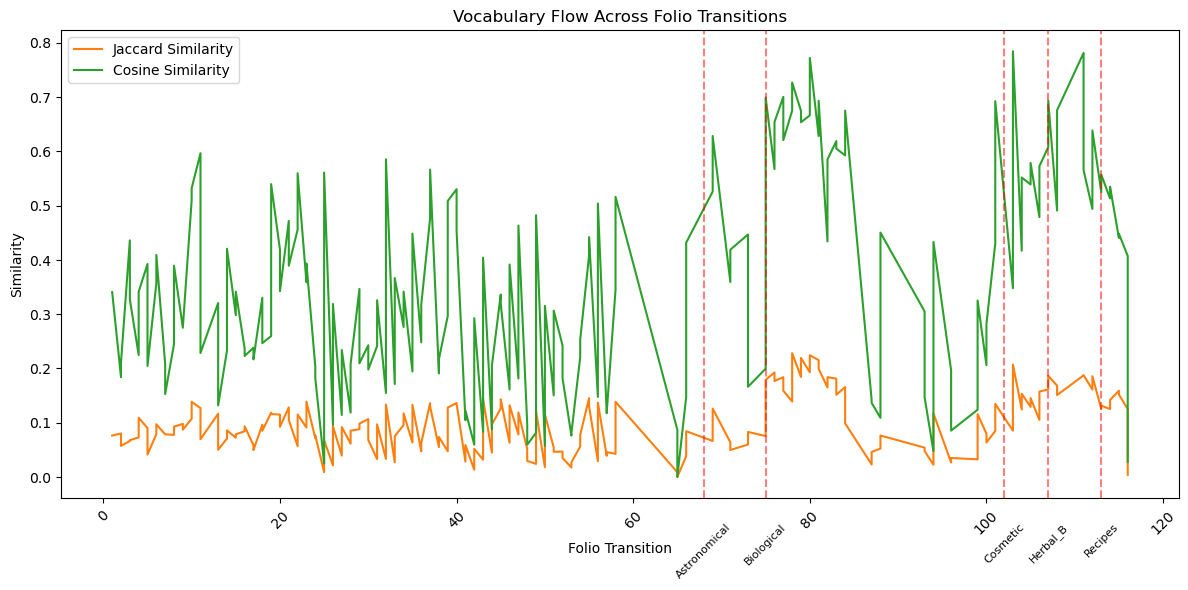

In [16]:
# Visualize Vocabulary Flow
flow_analyzer.visualize_flow(flow_df)